In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions, adjust_areas
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


## Scale optimization module

In [2]:
def scale_opt_obj(scale, organo, tensions_array):
    scaled_tensions_organo = organo.copy()
    scaled_tensions_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(scaled_tensions_organo,
                                                                             scale*tensions_array)
    Solver.find_energy_min(scaled_tensions_organo, geom, model)
    return np.sum(np.linalg.norm(_distance(organo, scaled_tensions_organo), axis=1))

In [3]:
def scan_scale_factor(organo, tensions_array,
                      lb=0.0, ub=10.0,
                      start_ss=1.0, end_ss=1e-3,
                      geom=geom, model=model):
    step_size = start_ss
    while step_size >= end_ss:
        facts = np.arange(lb, ub, step_size)
        dists = np.zeros(int((ub-lb)/step_size))
        for ind, fact in enumerate(facts):
            tmp_eptm = organo.copy()
            tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                             fact*tensions_array)
            Solver.find_energy_min(tmp_eptm, geom, model)
            dists[ind] = np.sum(np.linalg.norm(_distance(tmp_eptm, organo), axis=1))
        approx_argmin = np.argmin(dists)
        lb = max(0, lb + facts[approx_argmin] - 0.5*step_size)
        ub = lb + facts[approx_argmin] + 0.5*step_size
        step_size /= 10
    return facts[approx_argmin]
#scan_scale_factor(organo, initial_guess['tensions'])

In [4]:
def adjust_scale(organo, tensions_array,
                 lb=0.0, ub=10.0,
                 start_ss=1.0, end_ss=1e-3,
                 geom=geom, model=model,
                 **min_opt):
    tmp_eptm = organo.copy()
    initial_scale = scan_scale_factor(tmp_eptm, tensions_array,
                                      lb, ub, start_ss, end_ss,
                                      geom, model)
    scale_fact_res = optimize.minimize(scale_opt_obj,
                                       initial_scale,
                                       args=(tmp_eptm, tensions_array),
                                       **min_opt)
    return scale_fact_res.x

### Controled randomness

In [5]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)

### Generate the theoritical organoïd

In [6]:
seed = 1553
def create_organo(seed, nb_cells, r_in, r_out):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf= organo.Nf
    geom.update_all(organo)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }

    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)

    symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
    organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
    organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
    organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(1.0, 0.05, organo.Nf)

    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = organo.edge_df.line_tension

    organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(organo, geom, model) 
    return organo
organo = create_organo(seed, 20, 110, 150)

Reseting datasets values with new specs


### Creating a printing function

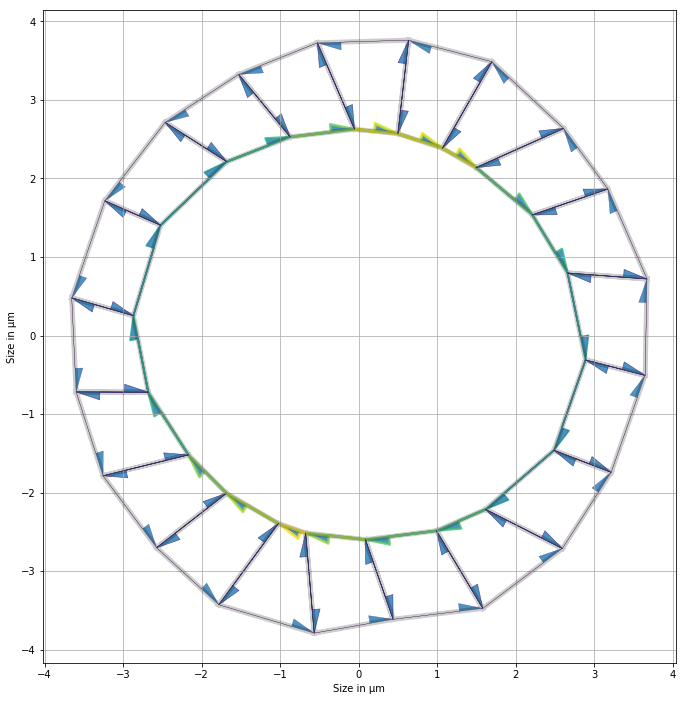

In [7]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

### Define the optimization parameters

In [8]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

### Define a result rendering function

In [9]:
def rendering_results(x_data, y_data, title, xlabel, ylabel, legend):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, '.', markersize=10, alpha=0.4)
    plt.plot(x_data, intercept+slope*np.array(x_data), '-')
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
    print('R value :', r_value,
          '\nStandard error :', (std/organo.Ne)**0.5,
          '\nDistance :', np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1)))

# Force inference with ONLY TENSIONS solved with NNLS

Solving time: 6.179899000000001


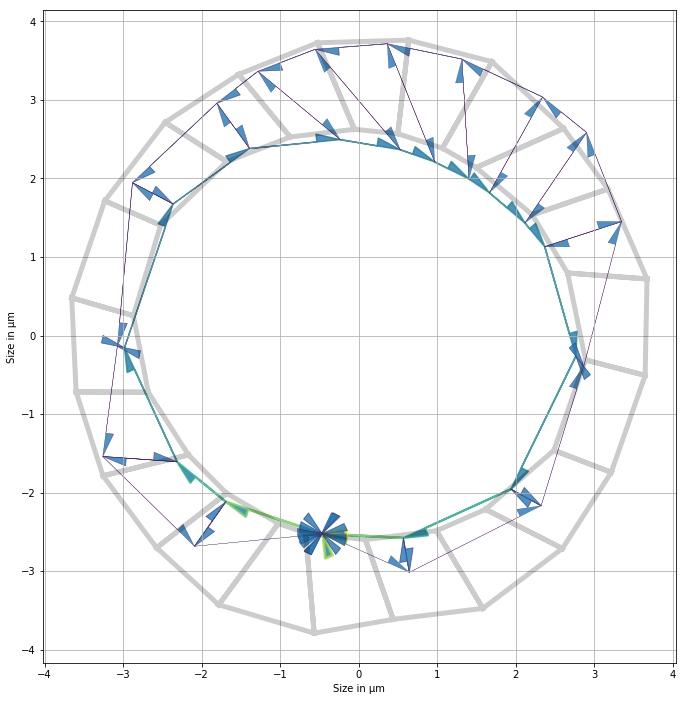

In [10]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
tensions_organo = organo.copy()
tensions_organo.edge_df.line_tension = prepare_tensions(tensions_organo,
                                                        initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_organo, False))
Solver.find_energy_min(tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_organo, False))
print_tensions(tensions_organo, organo)
#print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1))))

#### Comparaison des vraies tensions et des tensions inférées

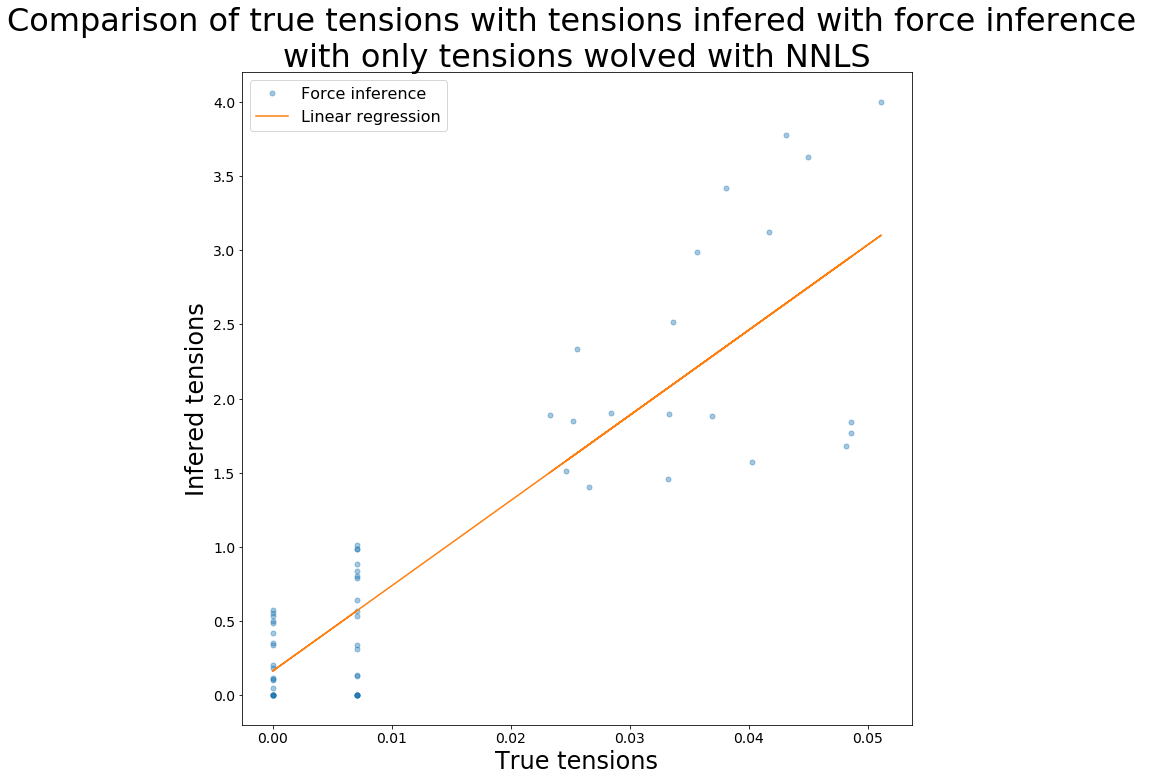

R value : 0.8815227874352544 
Standard error : 0.4435319754210306 
Distance : 31.946942500509017


In [11]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [12]:
true_tensions_t_nnls = []
errors_t_nnls  = []
infered_tensions_t_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_t_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_t_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    infered_tensions_t_nnls += list(initial_guess['tensions'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


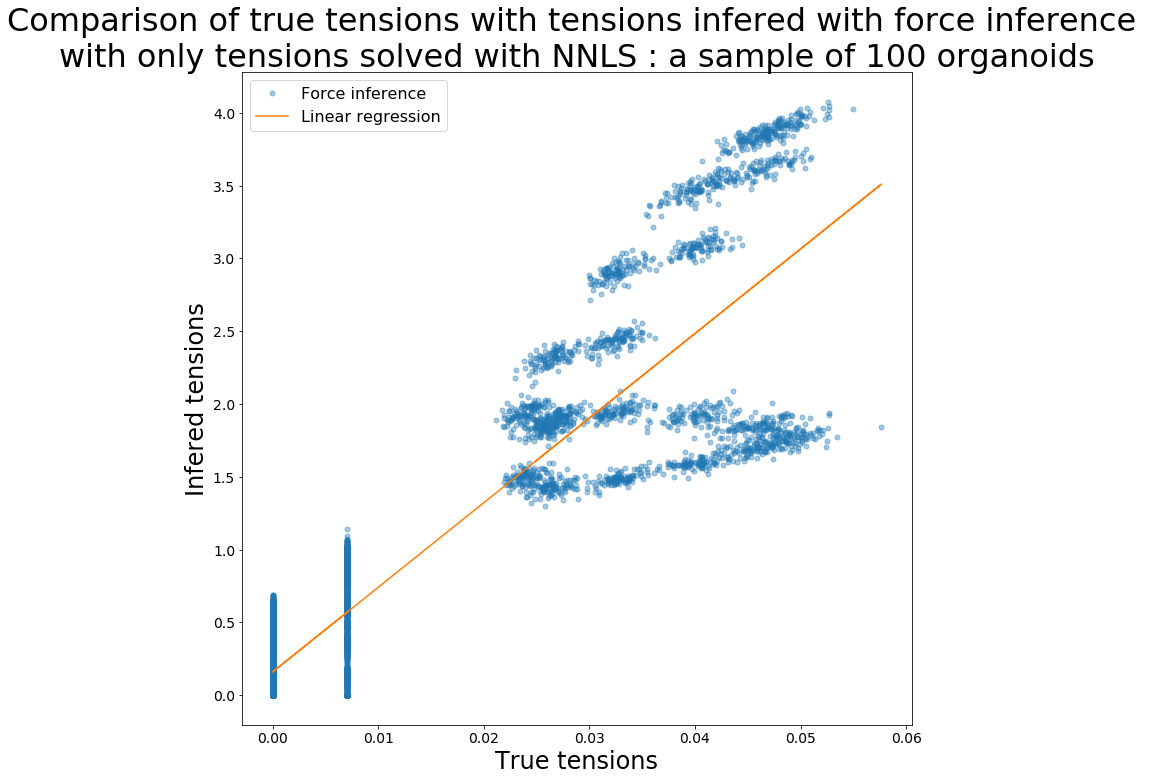

R value : 0.8861784395174196 
Standard error : 4.335959957953579 
Distance : 31.946942500509017


In [13]:
rendering_results(true_tensions_t_nnls,
                  infered_tensions_t_nnls,
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [14]:
print('Mean distance :', np.mean(errors_t_nnls),
      '\nMaximum distance :', np.max(errors_t_nnls))

Mean distance : 34.24325397452189 
Maximum distance : 46.772939507842295


# Rescaled force inference solved with NNLS for tensions only 

Solving time: 129.71755800000005


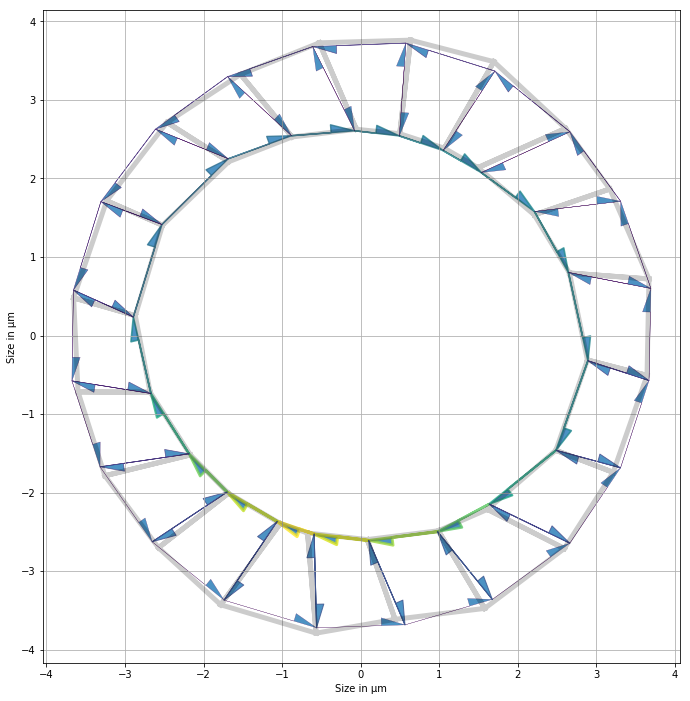

In [15]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_tensions_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})
rescaled_tensions_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_organo,
                                                                 opt_scale*initial_guess['tensions'])
Solver.find_energy_min(rescaled_tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_organo, organo)

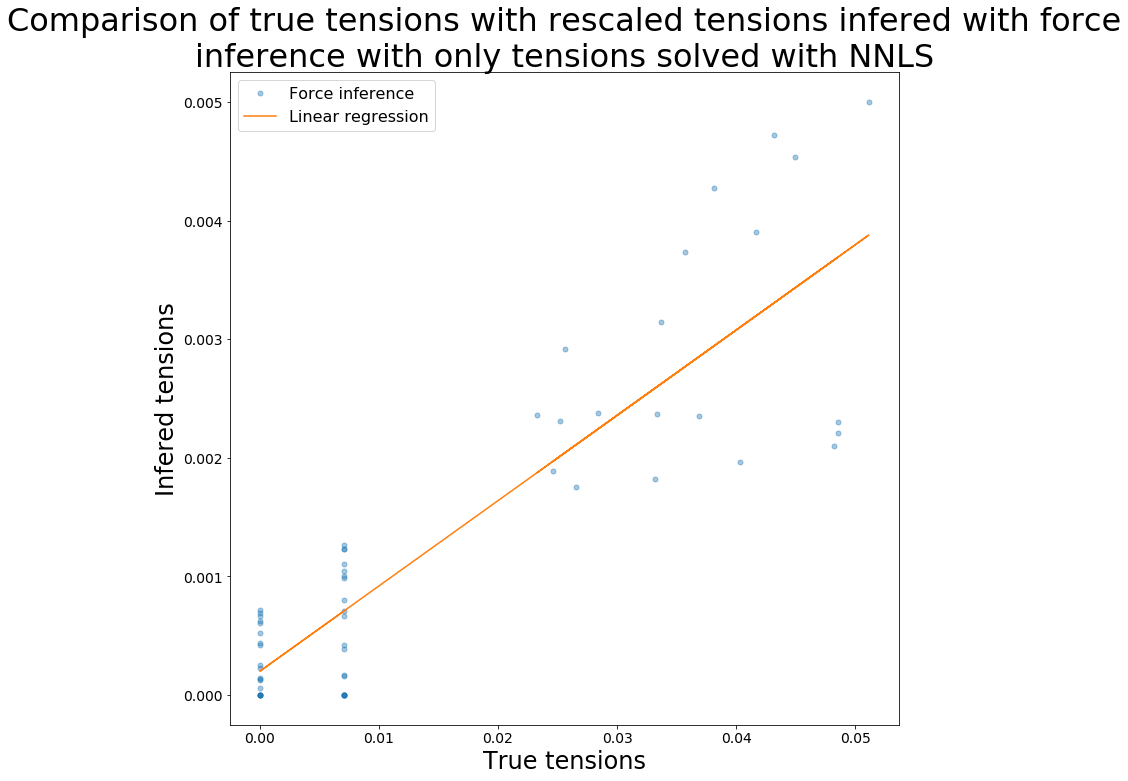

R value : 0.8815227874352541 
Standard error : 0.0005544149692762887 
Distance : 31.946942500509017


In [16]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  opt_scale*initial_guess['tensions'],
                  'Comparison of true tensions with rescaled tensions infered with force\n' +
                  'inference with only tensions solved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [17]:
true_tensions_rt_nnls = []
errors_rt_nnls  = []
infered_tensions_rt_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='')
    start = time.clock()
    tmp_eptm = eptm.copy()
    opt_scale = adjust_scale(organo,
                             initial_guess['tensions'],
                             **{'method':'Nelder-Mead'})
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     opt_scale*initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_rt_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_rt_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    infered_tensions_rt_nnls += list(opt_scale*initial_guess['tensions'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


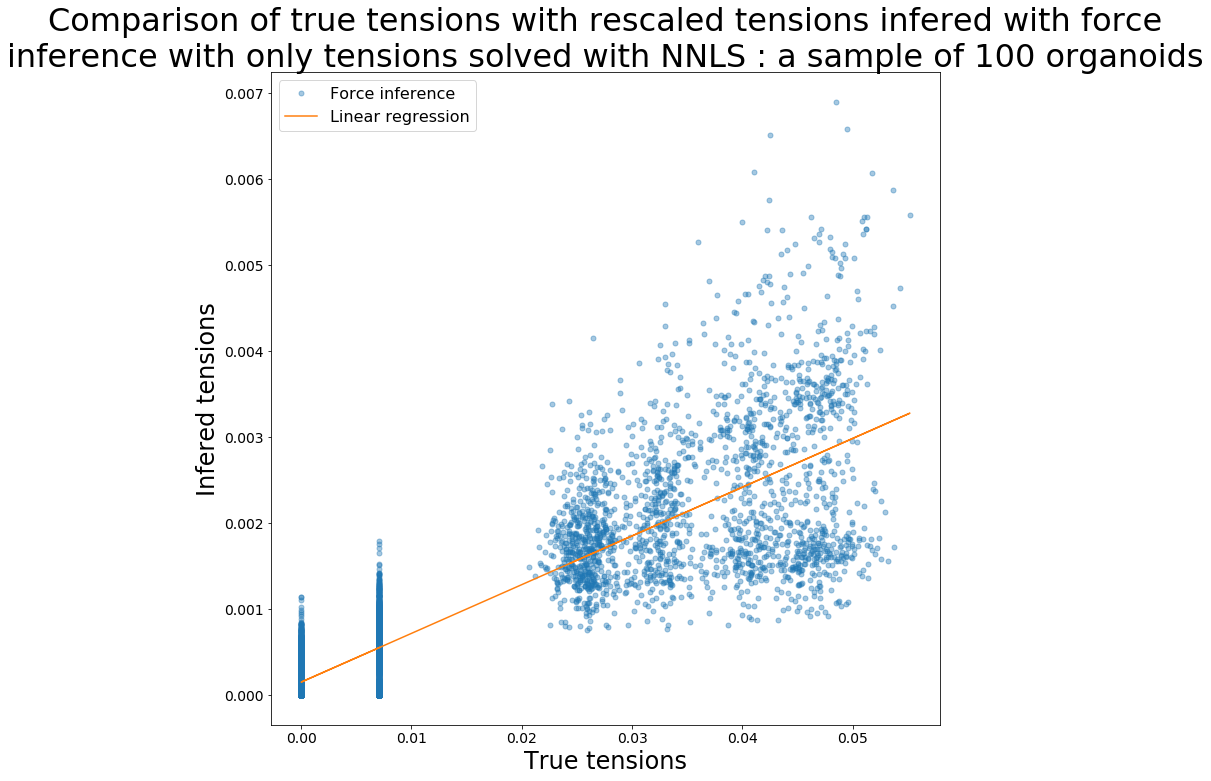

R value : 0.8480282204401284 
Standard error : 0.005059084208033024 
Distance : 31.946942500509017


In [18]:
rendering_results(true_tensions_rt_nnls,
                  infered_tensions_rt_nnls,
                  'Comparison of true tensions with rescaled tensions infered with force\n' +
                  'inference with only tensions solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [19]:
print('Mean distance :', np.mean(errors_rt_nnls),
      '\nMaximum distance :', np.max(errors_rt_nnls))

Mean distance : 2.942635883109527 
Maximum distance : 3.5758472098452803


# Force inference solved with NNLS for tensions and areas

Solving time: 9.814730999998574


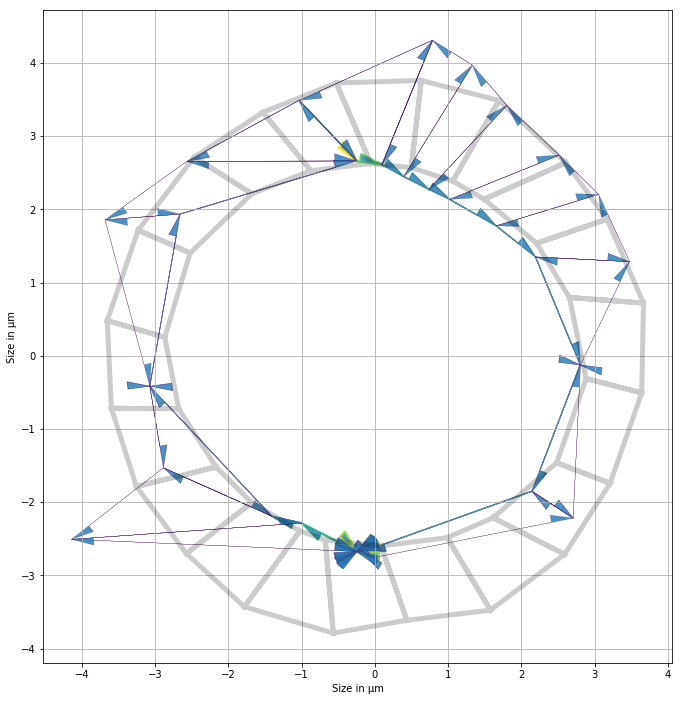

In [20]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo,
                                                     initial_guess['tensions'])
areas_organo.face_df.prefered_area = organo.face_df.area + initial_guess['areas'][:-1]
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(areas_organo, organo)

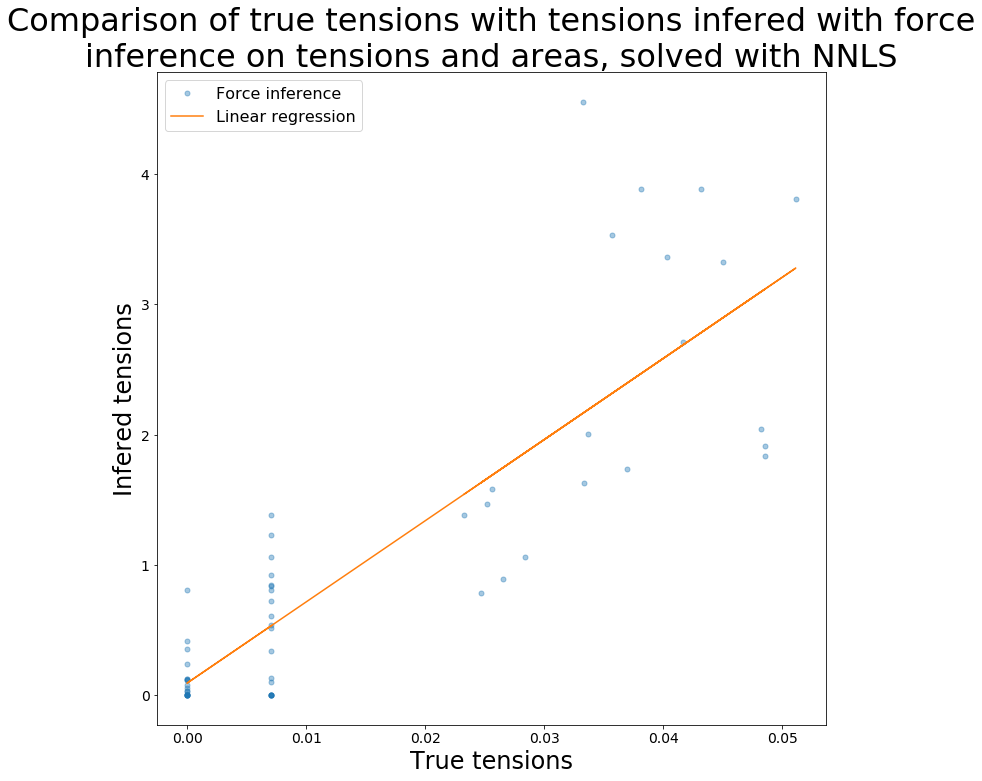

R value : 0.8565185152528715 
Standard error : 0.5408353439999392 
Distance : 31.946942500509017


In [21]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference on tensions and areas, solved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

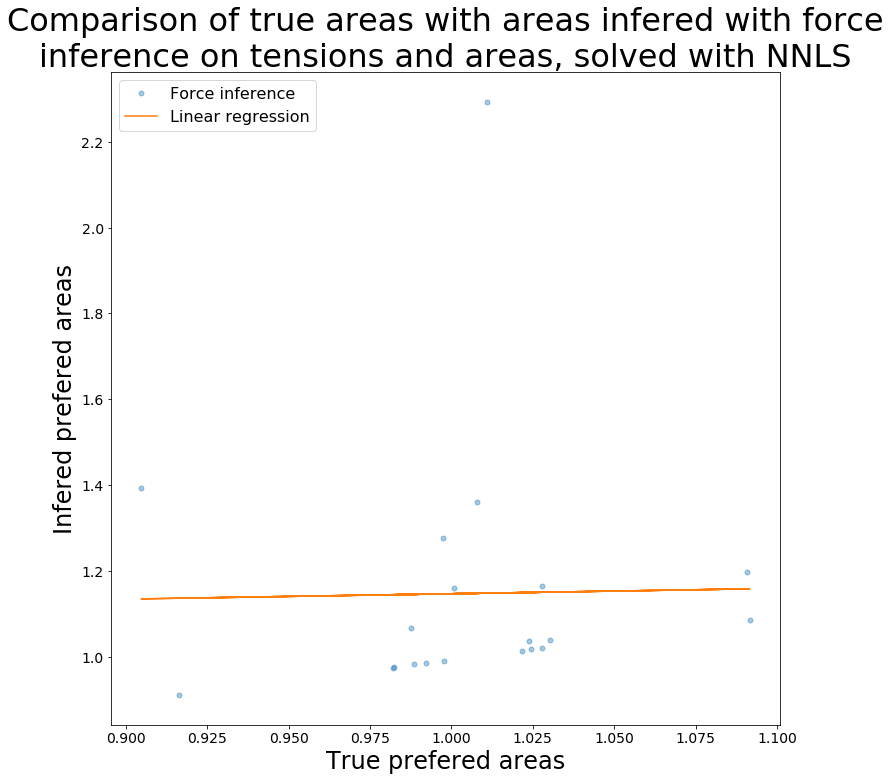

R value : 0.01843717556549683 
Standard error : 0.14632952328394794 
Distance : 31.946942500509017


In [22]:
rendering_results(organo.face_df.prefered_area,
                  areas_organo.face_df.prefered_area,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference on tensions and areas, solved with NNLS',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [23]:
true_tensions_a_nnls = []
true_areas_a_nnls = []
errors_a_nnls  = []
infered_tensions_a_nnls = []
infered_areas_a_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='areas')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_a_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_a_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    true_areas_a_nnls += list(eptm.face_df.prefered_area)
    infered_tensions_a_nnls += list(initial_guess['tensions'])
    infered_areas_a_nnls += list(initial_guess['areas'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


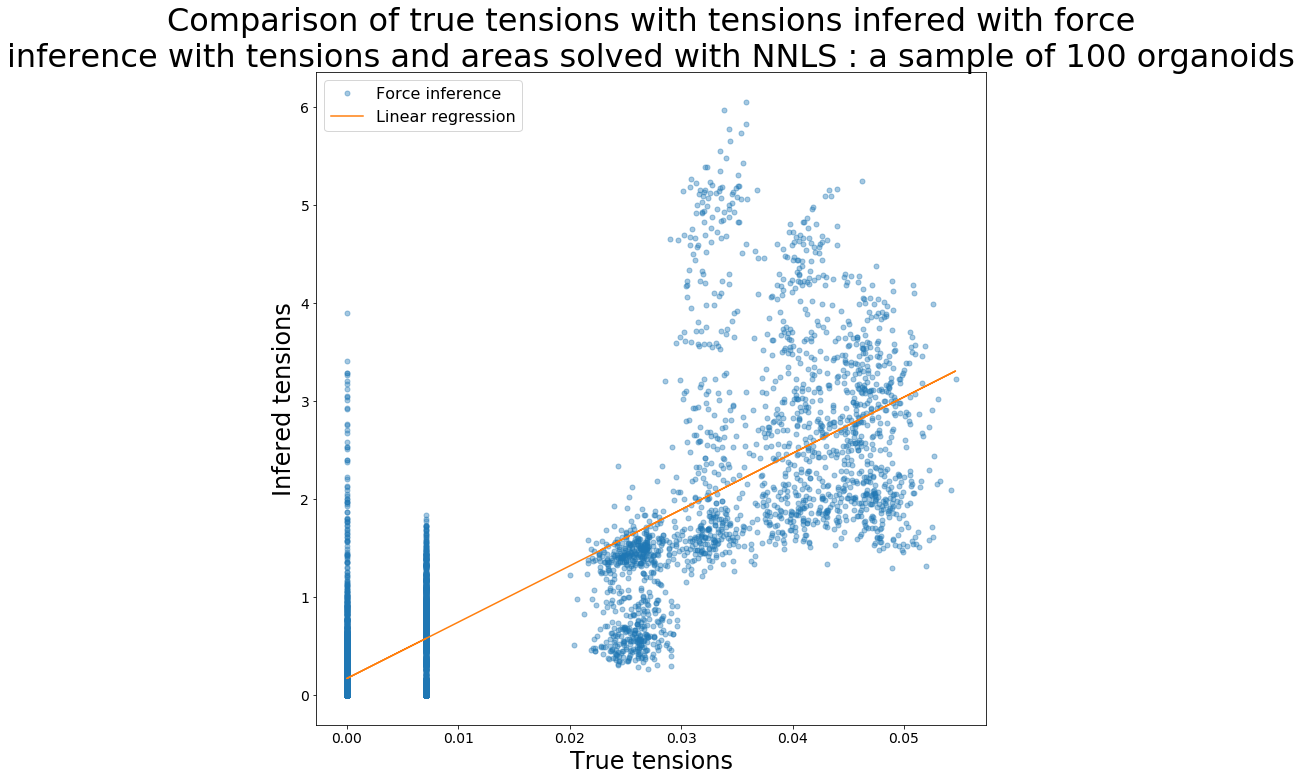

R value : 0.8037275178870381 
Standard error : 6.059149942639359 
Distance : 31.946942500509017


In [24]:

rendering_results(true_tensions_a_nnls,
                  infered_tensions_a_nnls,
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference with tensions and areas solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

(2000,) 2000


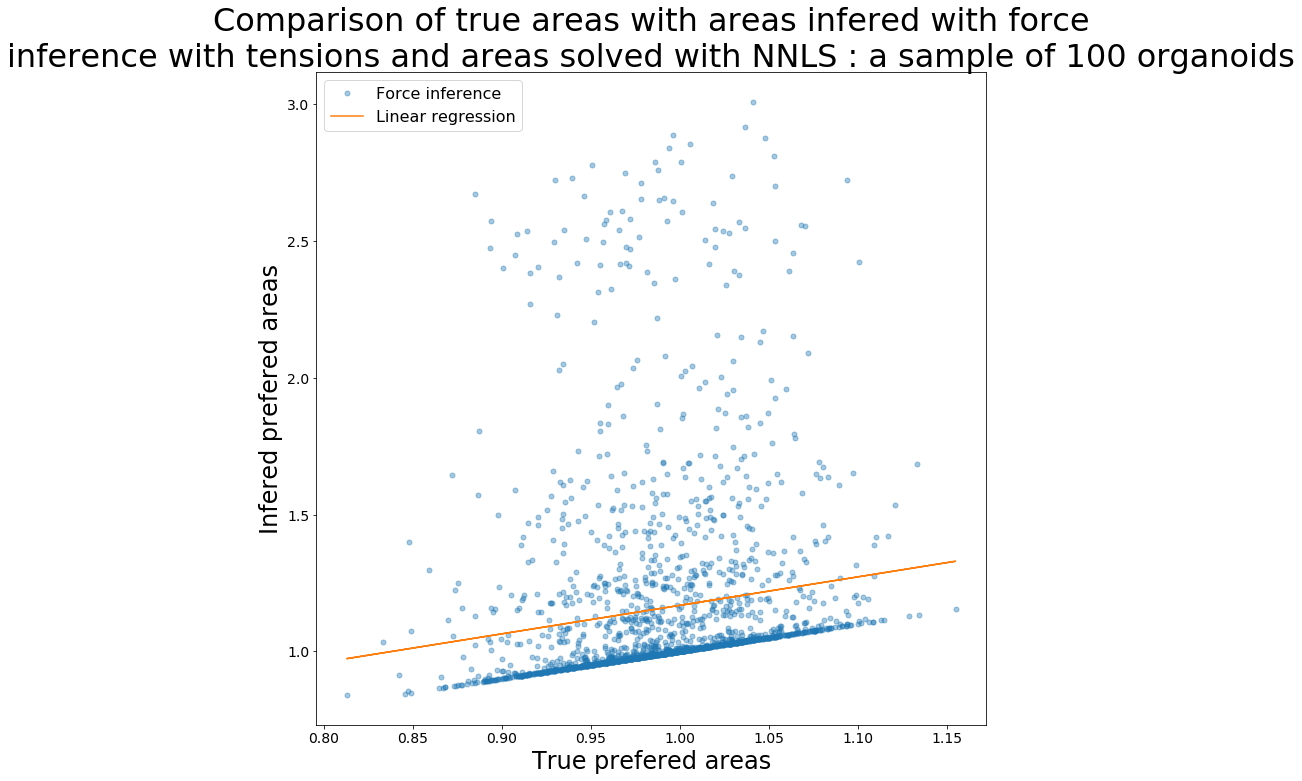

R value : 0.14306141503190806 
Standard error : 1.7634303218566598 
Distance : 31.946942500509017


In [25]:
print_infered_areas_a_nnls = np.concatenate([infered_areas_a_nnls[(organo.Nf+1)*i:(organo.Nf+1)*i+organo.Nf]
                                            for i in range(0, 100)])
print(print_infered_areas_a_nnls.shape, len(true_areas_a_nnls))
rendering_results(true_areas_a_nnls,
                  true_areas_a_nnls+print_infered_areas_a_nnls,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference with tensions and areas solved with NNLS : a sample of 100 organoids',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

In [26]:
print('Mean distance :', np.mean(errors_a_nnls),
      '\nMaximum distance :', np.max(errors_a_nnls))

Mean distance : 41.86914306082886 
Maximum distance : 58.752077689211134


# Rescaled force inference solved with NNLS for tensions and equilibrium areas 

Solving time: 233.56917500000054


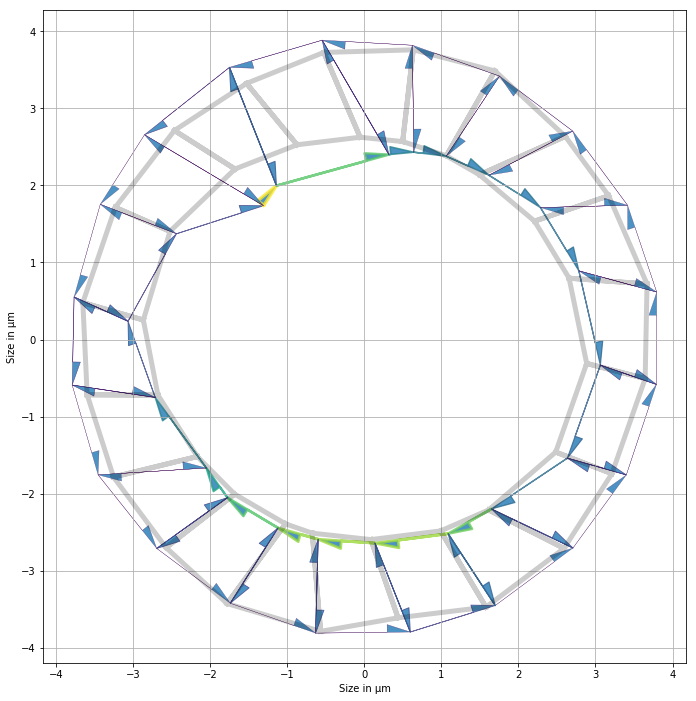

In [27]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
rescaled_areas_organo = organo.copy()
rescaled_areas_organo.face_df.loc[:, 'prefered_area'] = organo.face_df.area + initial_guess['areas'][:-1]
opt_scale = adjust_scale(rescaled_areas_organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})
rescaled_areas_organo.edge_df.line_tension = prepare_tensions(rescaled_areas_organo,
                                                              opt_scale*initial_guess['tensions'])
Solver.find_energy_min(rescaled_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_areas_organo, organo)

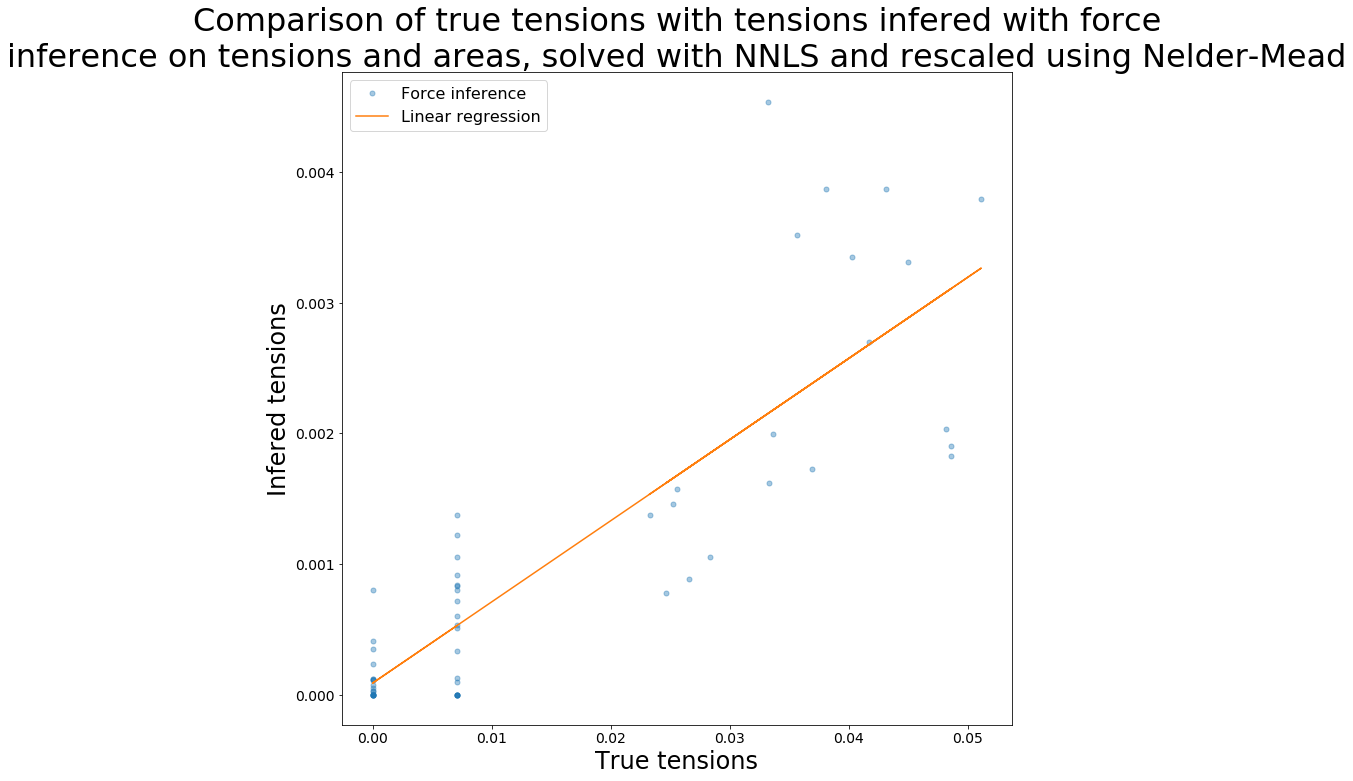

R value : 0.8565185152528713 
Standard error : 0.0005383001783249395 
Distance : 31.946942500509017


In [28]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference on tensions and areas, solved with NNLS and rescaled using Nelder-Mead',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

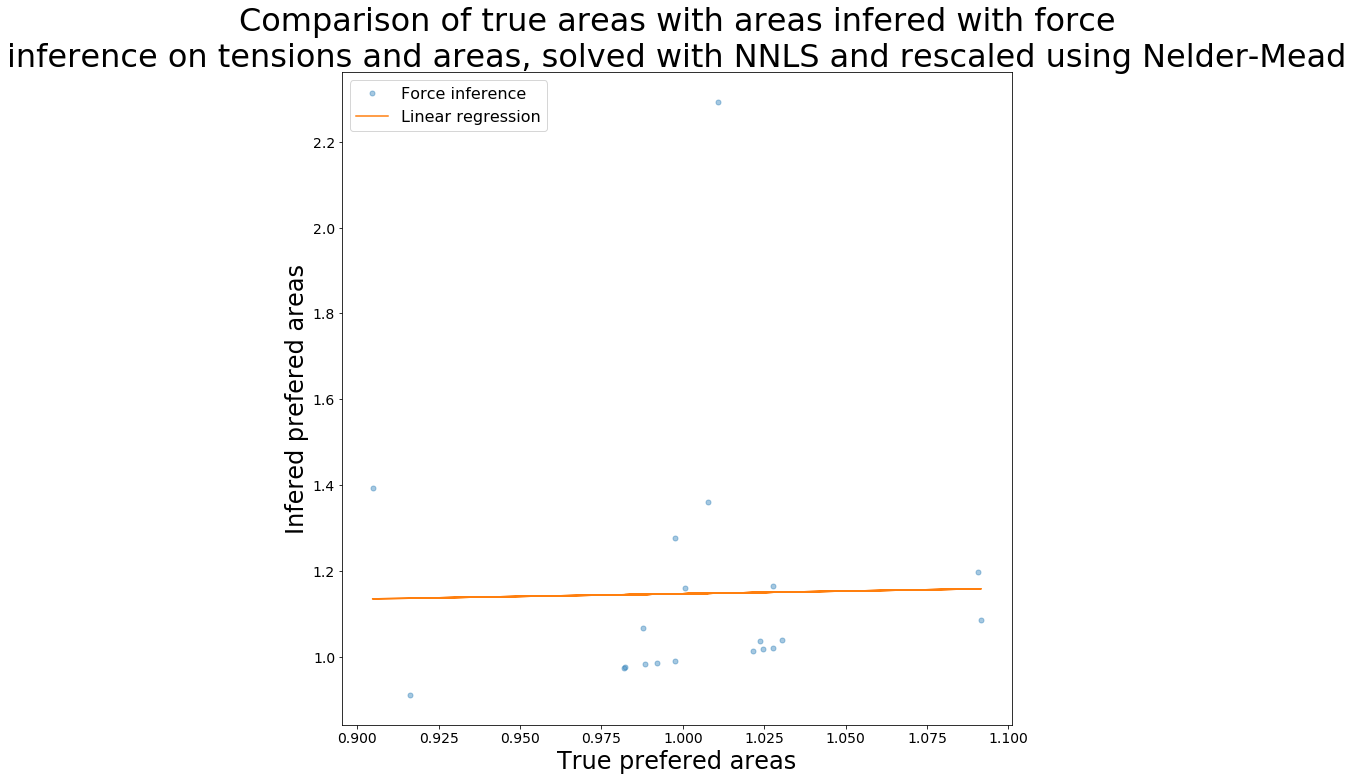

R value : 0.01843717556549683 
Standard error : 0.14632952328394794 
Distance : 31.946942500509017


In [29]:
rendering_results(organo.face_df.prefered_area,
                  rescaled_areas_organo.face_df.prefered_area,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference on tensions and areas, solved with NNLS and rescaled using Nelder-Mead',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [30]:
true_tensions_ra_nnls = []
true_areas_ra_nnls = []
errors_ra_nnls  = []
infered_tensions_ra_nnls = []
infered_areas_ra_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='areas')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.face_df.loc[:, 'prefered_area'] = organo.face_df.area + initial_guess['areas'][:-1]
    opt_scale = adjust_scale(organo,
                             initial_guess['tensions'],
                             **{'method':'Nelder-Mead'})
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     opt_scale*initial_guess['tensions'])    
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_ra_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_ra_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    true_areas_ra_nnls += list(eptm.face_df.prefered_area)
    infered_tensions_ra_nnls += list(initial_guess['tensions'])
    infered_areas_ra_nnls += list(initial_guess['areas'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


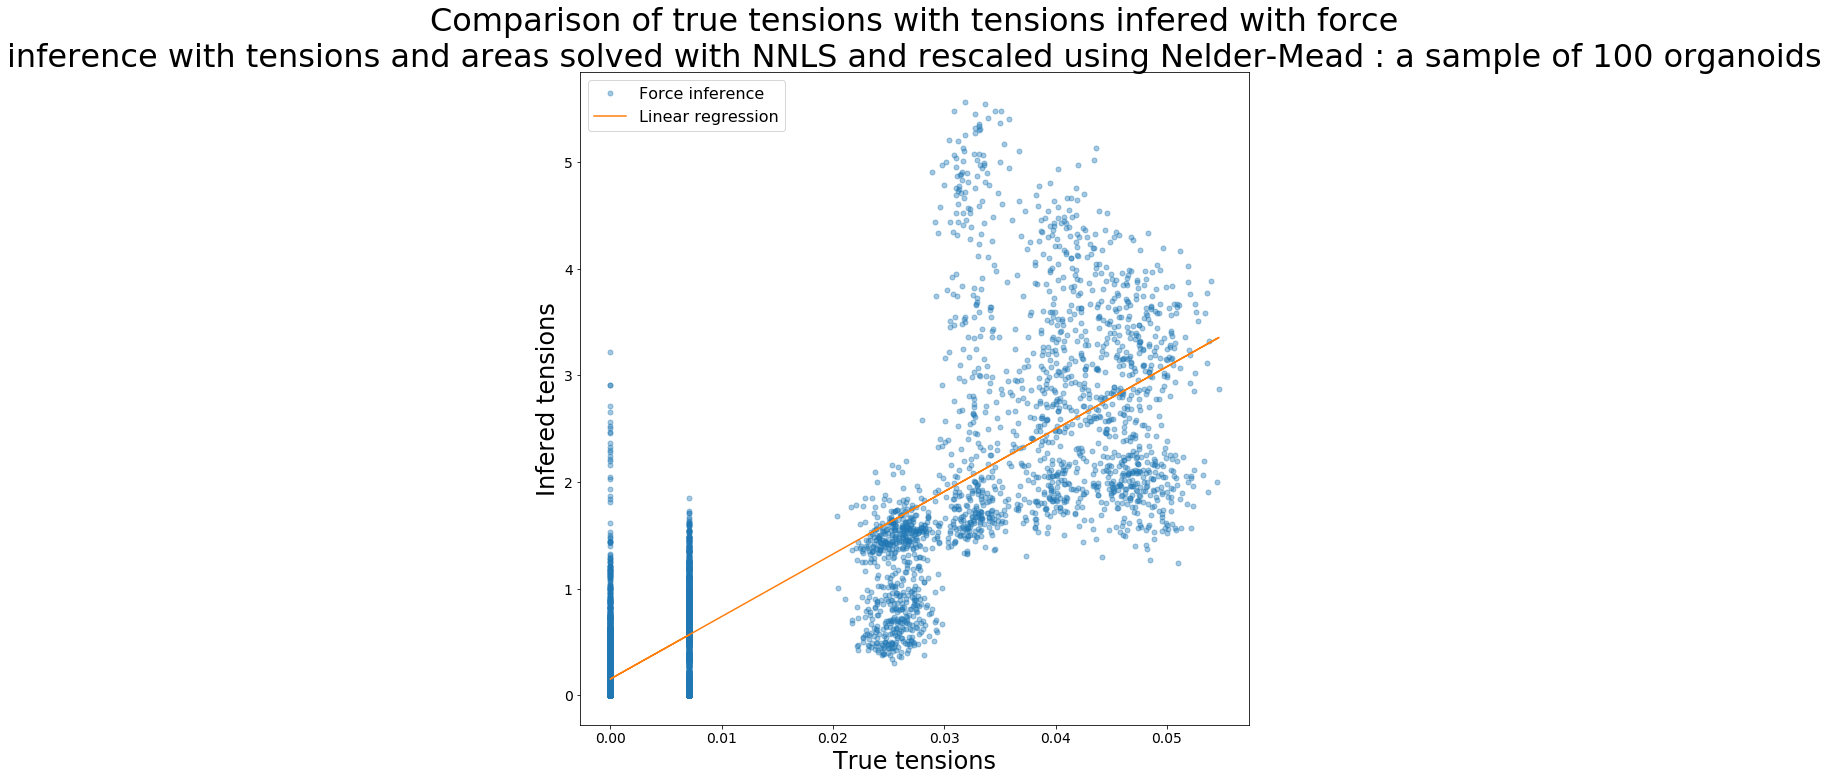

R value : 0.8239841081284863 
Standard error : 5.764529430575342 
Distance : 31.946942500509017


In [31]:
rendering_results(true_tensions_ra_nnls,
                  infered_tensions_ra_nnls,
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference with tensions and areas solved with NNLS and rescaled using Nelder-Mead : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [32]:
rendering_results(true_areas_ra_nnls,
                  infered_areas_ra_nnls,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference with tensions and areas solved with NNLS and rescaled using Nelder-Mead: a sample of 100 organoids',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

ValueError: all the input array dimensions except for the concatenation axis must match exactly